Here we importe the needed librairie



In [3]:
import numpy as np
import time
import os

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

In [4]:
dataset = "dataset/Train"

We set the subfolders where we will store the downloaded ressources

In [5]:
keras_cache_dir = os.path.join(os.getcwd(),'keras_cache')
os.makedirs(keras_cache_dir, exist_ok = True)

tfhub_cache_dir = os.path.join(os.getcwd(),'tfhub_cache')
os.makedirs(tfhub_cache_dir, exist_ok = True)
os.environ['TFHUB_CACHE_DIR'] = tfhub_cache_dir

We importe the pre-trained classifier image

In [6]:
classifier_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

We set the classifier variable

In [7]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])


We set a imagenet_labels variable in order to decode the prediction

In [8]:
labels_path = tf.keras.utils.get_file(
    'ImageNetLabels.txt',
    'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt',
    cache_dir = keras_cache_dir
)
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


We load the train dataset into our model

In [9]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8070 files belonging to 5 classes.
Using 6456 files for training.


We set an array that contain the class names

In [10]:
class_names = np.array(train_ds.class_names)
print(class_names)

['0' '1' '2' '3' '4']


We rescaling the image models from the training dataset

In [11]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

We prefetch the model with the tf.data.AUTOTUNE to inscrease the learning perfomance



In [12]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


We make a prediction with the actual model

In [14]:
result_batch = classifier.predict(train_ds)

Here is the predicted class name

In [15]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['combination lock', 'nematode', 'stopwatch', ..., 'stopwatch',
       'nematode', 'loupe'], dtype='<U30')

In [16]:
labels_path = tf.keras.utils.get_file(
    'ImageNetLabels.txt',
    'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt',
    cache_dir = keras_cache_dir
)
imagenet_labels = np.array(open(labels_path).read().splitlines())

We display the 30 first results from this prediction

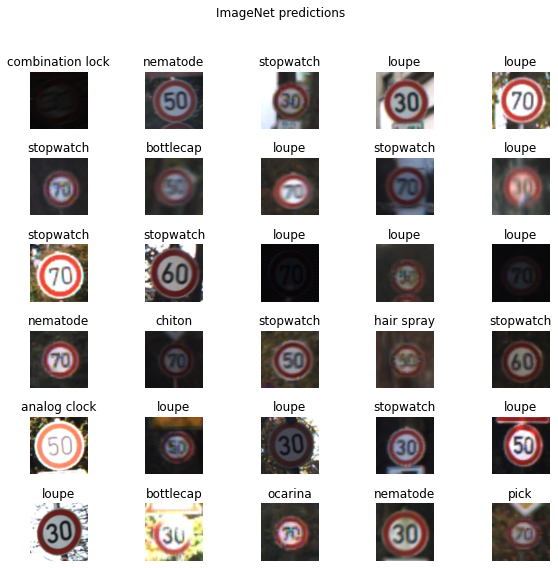

In [17]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

We download an headless model to manage the transfer learning

In [18]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" #@param {type:"string"}

We freeze the variable in the feature extractor

In [19]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

We put the new classification in the model

In [20]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


We configure the new model process with compile

In [21]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

We train the model

In [22]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

history = model.fit(train_ds, epochs=10,
                    callbacks=[batch_stats_callback])

Epoch 1/10
202/202 [==============================] - 216s 1s/step - loss: 0.8520 - acc: 0.6585
Epoch 2/10
202/202 [==============================] - 217s 1s/step - loss: 0.4937 - acc: 0.8324
Epoch 3/10
202/202 [==============================] - 221s 1s/step - loss: 0.3831 - acc: 0.8800
Epoch 4/10
202/202 [==============================] - 222s 1s/step - loss: 0.3209 - acc: 0.9051
Epoch 5/10
202/202 [==============================] - 223s 1s/step - loss: 0.2792 - acc: 0.9210
Epoch 6/10
202/202 [==============================] - 220s 1s/step - loss: 0.2485 - acc: 0.9286
Epoch 7/10
202/202 [==============================] - 220s 1s/step - loss: 0.2245 - acc: 0.9357
Epoch 8/10
202/202 [==============================] - 222s 1s/step - loss: 0.2051 - acc: 0.9430
Epoch 9/10
202/202 [==============================] - 219s 1s/step - loss: 0.1890 - acc: 0.9490
Epoch 10/10
202/202 [==============================] - 221s 1s/step - loss: 0.1753 - acc: 0.9546


We print 2 graphs of the evolution the model during the training

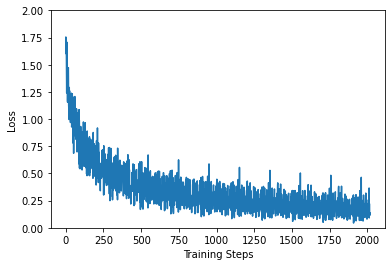

In [23]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses);

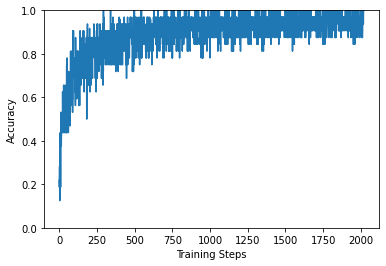

In [24]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc);

We make a predtion with the trained model

In [25]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

We display the 30 first result of this prectition

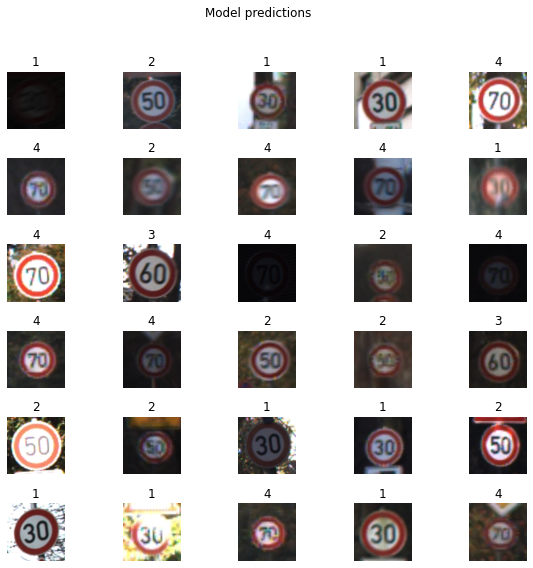

In [26]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

We save the model

You can change the export_path if needed

In [30]:
t = time.time()

export_path = f"saved_models/model_1"
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: saved_models/model_1/assets
INFO:tensorflow:Assets written to: saved_models/model_1/assets


'saved_models/model_1'



4) The new model train from the first one is able to classify the images, but only the six first class in the train dataset. We got an accuracy with an average of  0.9 after 10 Epoch of training.

